In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np

import re
import ast
import html
import glob
import spacy
import emoji
import string
import warnings

from datetime import datetime
from string import punctuation

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
import plotly.express as px
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer

warnings.filterwarnings('ignore', 'SelectableGroups dict interface')

In [4]:
nlp = spacy.load("en_core_web_lg")

In [5]:
frame = pd.read_csv("emails_dir/email_17-03-2023-14-46-07_17-03-2023-15-04-27.csv")
frame = frame[frame["id"] != "id"].reset_index(drop = True)
frame.shape

(2649, 8)

In [6]:
def search_pattern(x, pattern = '(.+?)<'):
    try:
        found = re.search(pattern, x).group(1)
    except AttributeError:
        found = np.nan
    return(found) 

In [7]:
## Data Preprocessing

frame["headers"] = frame["payload"].apply(lambda x:ast.literal_eval(x).get("headers"))
frame["headers_keys"] = frame["headers"].apply(lambda x: pd.DataFrame(x)["name"].str.lower().values.tolist())
frame["from"] = frame["headers"].apply(
    lambda x:dict(
        zip(pd.DataFrame(x)["name"].str.lower().values.tolist(), 
            pd.DataFrame(x)["value"].values.tolist()))["from"]
)

frame["from_email"] = frame["from"].apply(lambda x:search_pattern(x, "<(.+?)>"))
frame["from_name"] = frame["from"].apply(lambda x:search_pattern(x, "(.+?)<"))

frame_sub = frame[["subject" in elem for elem in frame["headers_keys"]]].reset_index(drop = True)
frame_sub["subject"] = frame_sub["headers"].apply(
    lambda x:dict(zip(pd.DataFrame(x)["name"].str.lower().values.tolist(), 
                      pd.DataFrame(x)["value"].values.tolist()))["subject"]
)

frame_sub["from_email"] = frame_sub["from_email"].fillna(frame_sub["from"])
frame_sub["from_name"] = frame_sub["from_name"].fillna(frame_sub["from"])
frame_sub["internalDateUsual"] = frame_sub["internalDate"].apply(lambda x:datetime.utcfromtimestamp(float(x)/1000).strftime('%Y-%m-%d %H:%M:%S'))
frame_sub["payload"] = frame_sub["payload"].apply(lambda x:ast.literal_eval(x))

frame_sub["subject"] = frame_sub["subject"].fillna("")
frame_sub["snippet"] = frame_sub["snippet"].fillna("")

frame_sub["emoji"] = frame_sub.apply(lambda x:[emoji.demojize(elem) for elem in emoji.distinct_emoji_list(x["subject"] + x["snippet"])], axis = 1)
frame_sub["subject-snippet"] = frame_sub["subject"] + ". " + frame_sub["snippet"]

frame_sub.head(2)

id          threadId  \
0  186eebaf75887159  186edd8192d21c9c   
1  186eeb8e50c375ac  186eeb8e50c375ac   

                                            labelIds  \
0  ['Label_6876589031423072572', 'IMPORTANT', 'CA...   
1  ['Label_7781807634347615867', 'CATEGORY_UPDATE...   

                                             snippet  \
0  Dear Card Member, Thank you for using your HDF...   
1  Quantitative Researcher and other roles are av...   

                                             payload  sizeEstimate  historyId  \
0  {'partId': '', 'mimeType': 'multipart/mixed', ...         12548   10396403   
1  {'partId': '', 'mimeType': 'multipart/alternat...         77563   10396358   

    internalDate                                            headers  \
0  1679042473000  [{'name': 'Delivered-To', 'value': 'aagrawal52...   
1  1679042337000  [{'name': 'Delivered-To', 'value': 'aagrawal52...   

                                        headers_keys  \
0  [delivered-to, received, x-google-smtp-source,...   
1  [delivered-to, received, x-google-smtp-source,...   

                                                from  \
0        HDFC Bank InstaAlerts <alerts@hdfcbank.net>   
1  LinkedIn Job Alerts <jobalerts-noreply@linkedi...   

                       from_email               from_name  \
0             alerts@hdfcbank.net  HDFC Bank InstaAlerts    
1  jobalerts-noreply@linkedin.com    LinkedIn Job Alerts    

                                         subject    internalDateUsual emoji  \
0  Alert :  Update on your HDFC Bank Credit Card  2023-03-17 08:41:13    []   
1       2 new jobs for “quantitative researcher”  2023-03-17 08:38:57    []   

                                     subject-snippet  
0  Alert :  Update on your HDFC Bank Credit Card....  
1  2 new jobs for “quantitative researcher”. Quan...

In [8]:
# Adapted from https://ryan-cranfill.github.io/sentiment-pipeline-sklearn-3/
def pipelinize(function, active=True):
    def list_comprehend_a_function(list_or_series, active=True):
        if active:
            return [function(i) for i in list_or_series]
        else: 
            return list_or_series
    return FunctionTransformer(list_comprehend_a_function, validate=False, kw_args={'active': active})

In [9]:
printable = set(string.printable)
def str_lower(arg_string):
    return(arg_string.lower())

def unescape_html_chars(arg_string):
    return(html.unescape(arg_string))

def remove_emoji(arg_string):
    return(emoji.replace_emoji(arg_string))

def handle_url(arg_string):
    return(re.sub(r"https?://\S+", " ", arg_string))

def remove_non_alpha(arg_string, char_set = printable):
    return("".join(filter(lambda x:x in printable, arg_string)))    

def handle_repeat_chars(arg_string):
    return(re.sub(r'(.)\1{3,}',r'\1', arg_string))

def tokenize_lemmatize_spacy(arg_text):
    doc = nlp(arg_text)
    tokenized_text = [token.lemma_ for token in doc if len(token) > 1]
    return(tokenized_text)

def text_preprocessing(arg):
    if isinstance(arg, str):
        return_arg = arg.strip()
        return_arg = re.sub(f"[{re.escape(punctuation)}]", " ", return_arg)
        return_arg = " ".join(return_arg.split())
        
        return(return_arg)
    
    elif isinstance(arg, list):
        return_arg = []
        for elem in arg:
            return_elem = elem.strip()
            return_elem = re.sub(f"[{re.escape(punctuation)}]", " ", return_elem)
            return_elem = " ".join(return_elem.split())
            return_arg.append(return_elem)
            
        return(return_arg)

In [10]:
components = [('case_lower', pipelinize(str_lower)), 
              ('unescape', pipelinize(unescape_html_chars)),
              ('demojize', pipelinize(remove_emoji)), 
              ('handle_url', pipelinize(handle_url)),
              ('remove_non_alpha', pipelinize(remove_non_alpha)),
              ('handle_repeat_chars', pipelinize(handle_repeat_chars)),
              ('tokenize', pipelinize(tokenize_lemmatize_spacy))]


text_cleaner_tokenizer = Pipeline(components)
text_cleaner_tokenizer.named_steps

{'case_lower': FunctionTransformer(func=<function pipelinize.<locals>.list_comprehend_a_function at 0x7ff33231de18>,
                     kw_args={'active': True}),
 'unescape': FunctionTransformer(func=<function pipelinize.<locals>.list_comprehend_a_function at 0x7ff33231dea0>,
                     kw_args={'active': True}),
 'demojize': FunctionTransformer(func=<function pipelinize.<locals>.list_comprehend_a_function at 0x7ff33231df28>,
                     kw_args={'active': True}),
 'handle_url': FunctionTransformer(func=<function pipelinize.<locals>.list_comprehend_a_function at 0x7ff31c750048>,
                     kw_args={'active': True}),
 'remove_non_alpha': FunctionTransformer(func=<function pipelinize.<locals>.list_comprehend_a_function at 0x7ff31c7500d0>,
                     kw_args={'active': True}),
 'handle_repeat_chars': FunctionTransformer(func=<function pipelinize.<locals>.list_comprehend_a_function at 0x7ff31c750158>,
                     kw_args={'active': True}),

In [11]:
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [12]:
def extract_user_email(elem):
    return(elem.split("@")[0])

def extract_domain(elem):
    return( ".".join(elem.split("@")[1].split(".")[:-1]))

def extract_domain_alt(elem):
    return(elem.split("@")[1])

In [13]:
def extract_mean_contextual_embedding(elem):
    if isinstance(elem, str):
        return(np.array([nlp(elem).vector]))
    else:
        res_elem = []
        for e1 in elem:
            res_elem.append(nlp(e1).vector)
    return(np.array(res_elem))

def identity_tokenizer(text):
    return text

In [14]:
tokenizer_tfidf_vectorizer = Pipeline(
    [("tokenizer", text_cleaner_tokenizer), 
     ("tfidf_vectorizer", TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False))])

raw_feature_extractor_text = ColumnTransformer(
    [("feature_subject", tokenizer_tfidf_vectorizer, 0), 
     ("feature_snippet", tokenizer_tfidf_vectorizer, 1)], 
    transformer_weights={"feature_subject": 1, "feature_snippet": 0.6})

# email_user_tokenizer_tfidf_vectorizer = Pipeline(
#     [("tokenizer", pipelinize(extract_user_email)), 
#      ("tfidf_vectorizer", TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, min_df=7))])

email_domain_tokenizer_tfidf_vectorizer = Pipeline(
    [("tokenizer", pipelinize(extract_domain_alt)), 
     ("tfidf_vectorizer", TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, min_df=5))])

feature_extractor_pipeline_text = Pipeline(
    [("raw_feature_extractor", raw_feature_extractor_text), 
     ('to_dense', DenseTransformer()),
     ('pca', PCA(n_components=0.9))])


# Pipeline([("email_user_tokenizer", email_user_tokenizer_tfidf_vectorizer), ('to_dense', DenseTransformer())])

# feature_extractor_pipeline_combined = ColumnTransformer(
#     [("text_feature_bow", feature_extractor_pipeline_text, [0,1]),
#      ("email_feature_user", 
#       Pipeline([
#           ("email_user_tokenizer", email_user_tokenizer_tfidf_vectorizer), 
#           ('to_dense', DenseTransformer())]), 2),
#      ("email_feature_domain", 
#       Pipeline([
#           ("email_domain_tokenizer", email_domain_tokenizer_tfidf_vectorizer), 
#           ('to_dense', DenseTransformer())]), 2),
#      ("context_embedding", FunctionTransformer(extract_mean_contextual_embedding), 3)]
# )



feature_extractor_pipeline_combined = ColumnTransformer(
    [("text_feature_bow", feature_extractor_pipeline_text, [0,1]),
     ("email_feature_domain", 
      Pipeline([
          ("email_domain_tokenizer", email_domain_tokenizer_tfidf_vectorizer), 
          ('to_dense', DenseTransformer())]), 2),
     ("context_embedding", FunctionTransformer(extract_mean_contextual_embedding), 3)],
    transformer_weights = {"text_feature_bow" : 1, 
                           "email_feature_domain" : 0.8, 
                           "context_embedding" : 1.3}
    
)

In [18]:
frame_sub["equity_random"] = ["Label_5479026944618646578" in elem for elem in frame_sub["labelIds"]]
frame_sub["equity_random"] = frame_sub["equity_random"].astype(int)
frame_sub["equity_random"].sum()

109

In [24]:
frame_sub[frame_sub["equity_random"] != 0][["subject", "snippet", "from_email"]]

subject  \
29                    Satisfaction Survey Questionnaire   
50       Shree Cement Limited - Notice of Postal Ballot   
100   The Federal Bank Ltd - Notice for passing of R...   
141                         Payment of Interim Dividend   
189   Varun Beverages Limited: 28th Annual General M...   
...                                                 ...   
1937  e-Voting for INFOSYS LIMITED will be open from...   
1942  Forty-fourth Annual General Meeting (Post-IPO)...   
1967     Thank You- Milestone of 3 Crore Demat Accounts   
1986  RELIANCE INDUSTRIES LIMITED - Meeting of the E...   
2018  Reliance Industries Limited - Unaudited standa...   

                                                snippet  \
29    ITC Limited CIN : L16005WB1910PLC001985 Regist...   
50    SHREE CEMENT LIMITED Regd. Office: Bangur Naga...   
100   THE FEDERAL BANK LIMITED CIN: L65191KL1931PLC0...   
141   ITC Limited CIN : L16005WB1910PLC001985 Regist...   
189   Varun Beverages Limited Registered Office: F-2...   
...                                                 ...   
1937  Central Depository Services (India) Limited De...   
1942  Registered Office: 3rd Floor, Maker Chambers I...   
1967  Document Sir/Madam, Greetings from CDSL! I sin...   
1986  Regd. Office: 3rd Floor, Maker Chambers IV, 22...   
2018  Registered Office: 3 rd Floor, Maker Chambers ...   

                                from_email  
29     InvestorServiceCentre@itclimited.in  
50    shreecement.evoting@linkintime.co.in  
100                  gogreen@cdslindia.com  
141    InvestorServiceCentre@itclimited.in  
189                       evoting@nsdl.com  
...                                    ...  
1937                 gogreen@cdslindia.com  
1942            investor.relations@ril.com  
1967                 gogreen@cdslindia.com  
1986            investor.relations@ril.com  
2018            investor.relations@ril.com  

[109 rows x 3 columns]

In [15]:
feature_mat = feature_extractor_pipeline_combined.fit_transform(frame_sub[["subject", "snippet", "from_email", "subject-snippet"]])

In [26]:
feature_mat_sub1 = feature_mat[frame_sub["equity_random"] != 0, :]
feature_mat_sub1.shape

(109, 1450)

In [27]:
feature_mat_sub2 = feature_mat[frame_sub["equity_random"] == 0, :]
feature_mat_sub2.shape

(2699, 1450)

In [28]:
from sklearn.metrics.pairwise import cosine_distances

In [34]:
dist1 = cosine_distances(feature_mat_sub2, feature_mat_sub1)

In [55]:
for elem in frame_sub_sub2.iloc[np.min(dist1, axis = 1).argsort()[:100]][["from_email", "subject", "snippet"]].iterrows():
    print(elem[1][0])
    print(elem[1][1])
    print(elem[1][2])
    print("----" * 10)

donotreply.evoting@cdslindia.co.in
e-Voting FOR HDFC BANK-EQ1/- will be OPEN FROM 24-02-2023 09:00:00 TO 25-03-2023 17:00:00 AND Meeting ON NA
Central Depository Services (India) Limited Dear Shareholder, Greetings from CDSL! Reminder for e-Voting of HDFC BANK-EQ1/- e-Voting Details: Commencement of e-voting Date &amp; Time 24-02-2023 09:00:
----------------------------------------
donotreply.evoting@cdslindia.co.in
e-Voting FOR FEDERAL BANK EQ 2/- will be OPEN FROM 08-03-2023 09:00:00 TO 06-04-2023 17:00:00 AND Meeting ON NA
Central Depository Services (India) Limited Dear Shareholder, Greetings from CDSL! Reminder for e-Voting of FEDERAL BANK EQ 2/- e-Voting Details: Commencement of e-voting Date &amp; Time 08-03-2023 09:
----------------------------------------
Complianceofficer@firstsource.com
Audited Financial Results for quarter ended 30th June 2021
Dear Shareholder/(s), Trust this finds you well. Your Company is pleased to announce its Audited Standalone and Consolidated Financi

In [58]:
del(dist1)

In [39]:
frame_sub_sub1 = frame_sub[frame_sub["equity_random"] != 0].reset_index(drop = True)
frame_sub_sub2 = frame_sub[frame_sub["equity_random"] == 0].reset_index(drop = True)

In [45]:
frame_sub_sub2.iloc[1808]

id                                                    17af8d32396d3cf5
threadId                                              17af8d32396d3cf5
labelIds                                 ['CATEGORY_UPDATES', 'INBOX']
snippet              Dear Shareholder/(s), Trust this finds you wel...
payload              {'partId': '', 'mimeType': 'multipart/mixed', ...
sizeEstimate                                                   1616939
historyId                                                      7185206
internalDate                                             1627671649000
headers              [{'name': 'Delivered-To', 'value': 'aagrawal52...
headers_keys         [delivered-to, received, x-google-smtp-source,...
from                                 Complianceofficer@firstsource.com
from_email                           Complianceofficer@firstsource.com
from_name                            Complianceofficer@firstsource.com
subject              Audited Financial Results for quarter ended 30...
intern

In [49]:
px.box(y = np.min(dist1, axis = 1))

/Users/aayushagrawal/anaconda3/lib/python3.7/site-packages/fastcluster.py:26: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/Users/aayushagrawal/anaconda3/lib/python3.7/site-packages/fastcluster.py:26: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



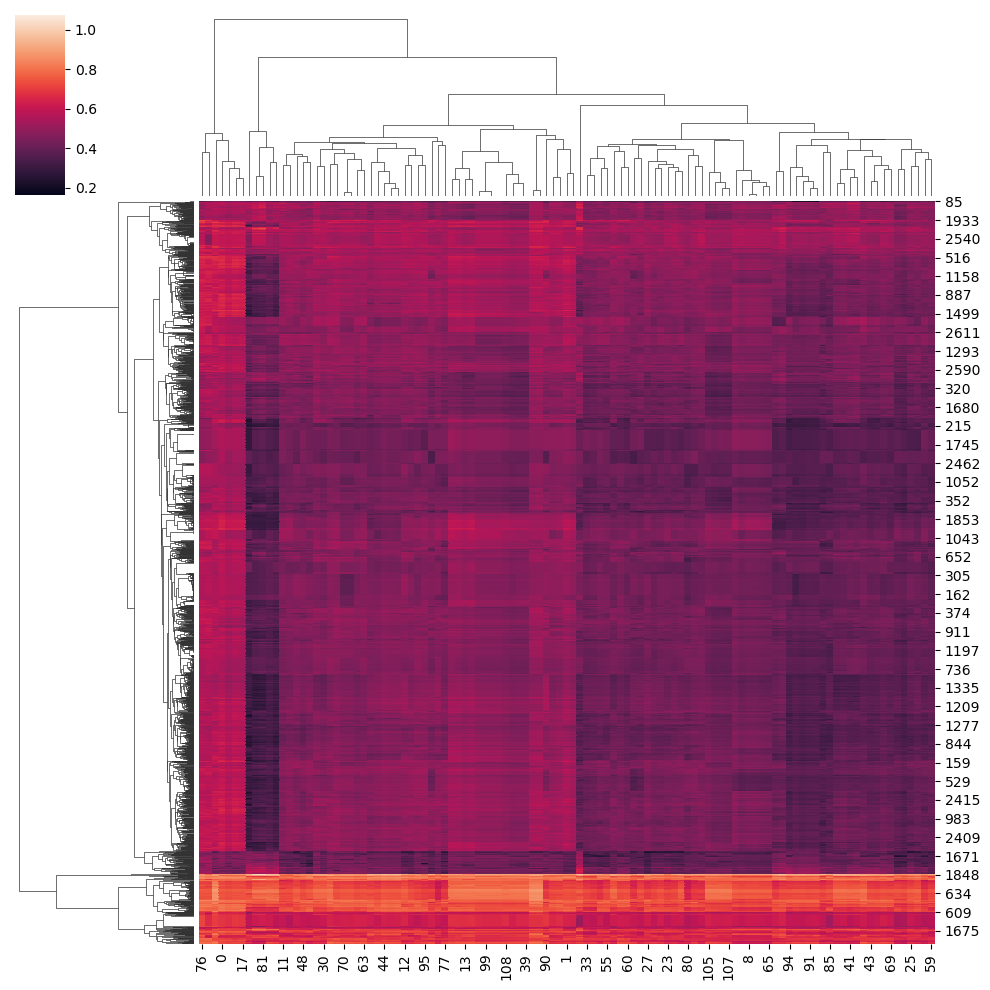

In [41]:
import seaborn as sns
sns.clustermap(dist1)

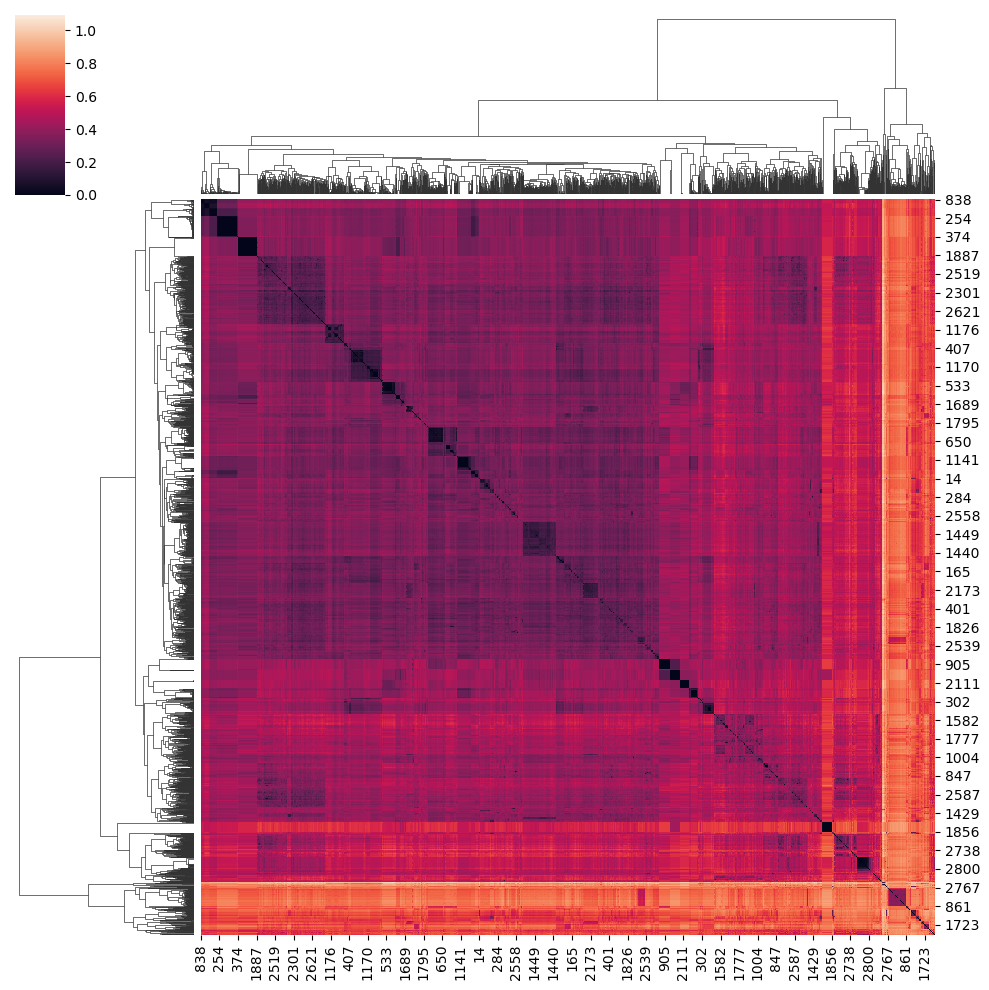

In [42]:
dist2 = cosine_distances(feature_mat)
sns.clustermap(dist2)

In [16]:
for i in range(feature_mat.shape[1]):
    frame_sub[f"vect_comp_{i}"] = feature_mat[:,i]
frame_sub.shape

(2645, 1433)

In [17]:
frame_sub_dedup = frame_sub.drop_duplicates("subject-snippet").reset_index(drop = True).copy()
frame_sub_dedup.shape

(2318, 1433)

In [18]:
from sklearn.cluster import OPTICS
clust = OPTICS(min_samples=5, xi = 0.02)
clust.fit(frame_sub_dedup[[f"vect_comp_{i}" for i in range(feature_mat.shape[1])]].values)

OPTICS(xi=0.02)

In [19]:
space = np.arange(frame_sub_dedup[[f"vect_comp_{i}" for i in range(feature_mat.shape[1])]].values.shape[0])
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]


df_clust_optics = pd.DataFrame(
    np.array([space.tolist(), 
              reachability.tolist(), 
              frame_sub_dedup.iloc[clust.ordering_]["snippet"].values.tolist(), 
              frame_sub_dedup.iloc[clust.ordering_]["subject"].values.tolist(),
              frame_sub_dedup.iloc[clust.ordering_]["from_email"].values.tolist(),
              labels.tolist()]).T, 
    columns = ["Index", "Reachability", "Snippet", "Subject", "From", "Labels"])
df_clust_optics.head()

Index        Reachability  \
0     0                 inf   
1     1  1.7116744874818086   
2     2  1.7061687990913805   
3     3  1.6779230260986524   
4     4  1.6779230260986602   

                                             Snippet  \
0  Dear Card Member, Thank you for using your HDF...   
1  Dear Card Member, Thank you for using your HDF...   
2  Dear Card Member, Thank you for using your HDF...   
3  Dear Card Member, Thank you for using your HDF...   
4  Important update regarding your HDFC Bank Cred...   

                                         Subject                 From Labels  
0  Alert :  Update on your HDFC Bank Credit Card  alerts@hdfcbank.net     -1  
1  Alert :  Update on your HDFC Bank Credit Card  alerts@hdfcbank.net     -1  
2  Alert :  Update on your HDFC Bank Credit Card  alerts@hdfcbank.net     -1  
3  Alert :  Update on your HDFC Bank Credit Card  alerts@hdfcbank.net     -1  
4    View: Account update for your HDFC Bank A/c  alerts@hdfcbank.net     -1

In [20]:
px.scatter(df_clust_optics, x = "Index", y = "Reachability", hover_data=["Snippet", "Subject", "From"], color = "Labels")

In [24]:
from sklearn.cluster import OPTICS
clust_1 = OPTICS(min_samples=10, xi = 0.1)
clust_1.fit(frame_sub_dedup[[f"vect_comp_{i}" for i in range(feature_mat.shape[1])]].values)

OPTICS(min_samples=10, xi=0.1)

In [25]:
space_1 = np.arange(frame_sub_dedup[[f"vect_comp_{i}" for i in range(feature_mat.shape[1])]].values.shape[0])
reachability_1 = clust_1.reachability_[clust_1.ordering_]
labels_1 = clust_1.labels_[clust_1.ordering_]


df_clust_1_optics = pd.DataFrame(
    np.array([space_1.tolist(), 
              reachability_1.tolist(), 
              frame_sub_dedup.iloc[clust_1.ordering_]["snippet"].values.tolist(), 
              frame_sub_dedup.iloc[clust_1.ordering_]["subject"].values.tolist(),
              frame_sub_dedup.iloc[clust_1.ordering_]["from_email"].values.tolist(),
              labels_1.tolist()]).T, 
    columns = ["Index", "Reachability", "Snippet", "Subject", "From", "Labels"])
df_clust_1_optics.head()

Index        Reachability  \
0     0                 inf   
1     1  1.9510416902169399   
2     2  1.9510416902169399   
3     3   1.930446867606932   
4     4   1.930446867606932   

                                             Snippet  \
0  Dear Card Member, Thank you for using your HDF...   
1  Dear Card Member, Thank you for using your HDF...   
2  Dear Card Member, Thank you for using your HDF...   
3  Dear Card Member, Thank you for using your HDF...   
4  Important update regarding your HDFC Bank Cred...   

                                         Subject                 From Labels  
0  Alert :  Update on your HDFC Bank Credit Card  alerts@hdfcbank.net     -1  
1  Alert :  Update on your HDFC Bank Credit Card  alerts@hdfcbank.net     -1  
2  Alert :  Update on your HDFC Bank Credit Card  alerts@hdfcbank.net     -1  
3  Alert :  Update on your HDFC Bank Credit Card  alerts@hdfcbank.net     -1  
4    View: Account update for your HDFC Bank A/c  alerts@hdfcbank.net     -1

In [26]:
px.scatter(df_clust_1_optics, x = "Index", y = "Reachability", hover_data=["Snippet", "Subject", "From"], color = "Labels")

In [33]:
print(frame_sub[(frame_sub["from_email"] == "alerts@hdfcbank.net")]["subject"].unique())

['Alert :  Update on your HDFC Bank Credit Card'
 'View: Account update for your HDFC Bank A/c']


In [28]:
frame_sub["from_email_domain"] = frame_sub["from_email"].apply(lambda x:x.split("@")[1])
frame_sub.groupby("from_email_domain").size().sort_values(ascending = False)

from_email_domain
gmail.com                          517
makemytrip.com                     137
businessmint.com                   135
linkedin.com                       122
nse.co.in                          100
                                  ... 
mailers.bigbazaar.com                1
mailer.zerodha.net                   1
creyalearning.com                    1
loyalty.email-marriott.com           1
abhi.hiadityabirlacapital.co.in      1
Length: 204, dtype: int64

In [29]:
frame_sub.groupby("from_email_domain").size().sort_values(ascending = False).head(20)

from_email_domain
gmail.com                      517
makemytrip.com                 137
businessmint.com               135
linkedin.com                   122
nse.co.in                      100
cdslindia.co.in                 99
kfintech.com                    94
capitalmind.in                  92
hindustantimesnewletter.com     86
email-marriott.com              74
google.com                      64
nsdl.co.in                      61
townscript.com                  43
bseindia.in                     42
hdfcbank.net                    40
interactive.wsj.com             39
cdslstatement.com               34
linkintime.co.in                33
wsj.com                         33
jupiter.money                   31
dtype: int64

In [32]:
frame_sub.groupby("from_email_domain")["threadId"].nunique().sort_values(ascending = False).head(50)

from_email_domain
gmail.com                      408
businessmint.com               135
makemytrip.com                 129
linkedin.com                   111
nse.co.in                       96
capitalmind.in                  92
kfintech.com                    91
cdslindia.co.in                 87
hindustantimesnewletter.com     86
email-marriott.com              74
google.com                      63
nsdl.co.in                      61
townscript.com                  43
bseindia.in                     42
interactive.wsj.com             39
hdfcbank.net                    38
cdslstatement.com               33
linkintime.co.in                33
wsj.com                         33
info.wintwealth.com             27
alertsmailer.zerodha.net        24
livemint.net                    24
vestedfinance.co                24
reportsmailer.zerodha.net       23
mlwhiz.com                      20
cdslindia.com                   20
isical.ac.in                    19
procam.in                       18
de

In [36]:
frame_sub.groupby("from_email_domain")["threadId"].nunique().sort_values(ascending = False)[50:100]

from_email_domain
email.apple.com                 7
weekendinvesting.com            7
fisdom.com                      7
itclimited.in                   6
tatasteel.com                   6
mail.notion.so                  6
youtube.com                     6
asiastore.fcbayern.com          6
audible.in                      6
rediffmail.com                  5
smallcase.com                   5
stripe.com                      5
instahyre.com                   5
geeksonfeet.com                 5
ustraveldocs.com                5
email.clubvistara.com           5
goathlos.com                    5
privaterelay.appleid.com        4
dhl-news.com                    4
docusign.net                    4
apple.com                       4
duolingo.com                    4
indiacommunications.citi.com    4
marketing.goindigo.in           4
agents.icims.com                4
gomotive.com                    3
tenorshare.com                  3
send.grammarly.com              3
oneglint.com                  

In [74]:
" OR ".join(frame_sub.groupby("from_email_domain")["threadId"].nunique().sort_values(ascending = False)[300:350].index)

'applytojob.com OR tatamf.in OR angel.co OR bluejeans.com OR talent.icims.com OR tm.openai.com OR swyng.in OR smonk.in OR pricelabs.freshteam.com OR smartbuyoffers.co OR haas.berkeley.edu OR kreditbee.in OR leadschool.in OR googlemail.com OR lifeinsurance.adityabirlacapital.org OR getsphere.com OR getpostman.com OR mailer.zerodha.net OR mailers.bigbazaar.com OR mailers.tata-sky.in OR firstsource.com OR manhattanprep.com OR marketing.angel.co OR ezjobs.io OR eu.playstationmail.net OR espn.com OR jobvite.com OR jiraaf.com OR communication.clubvistara.com OR abhinav.com OR indiacommunications.citi.com OR indiainxga.com OR indiapost.gov.in OR idbiintech.com OR info.paytmfirstgames.com OR info.paytmmoney.com OR icicisecurities.com OR icebergapp.com OR hyd.deshaw.com OR integratedindia.in OR interact.coursehero.com OR hike.in OR hi.wellfound.com OR hdfclife.com OR hdfcbank.com OR mycardshdfcbank.co OR email.coursera.org OR myfitnesspal.com OR myimaginestore.com OR quadeyesecurities.com'

In [48]:
frame_sub[frame_sub["from_email_domain"] == "hdfcbank.net"]["from_email"].unique()

array(['alerts@hdfcbank.net', 'informations@hdfcbank.net',
       'information@hdfcbank.net', 'hdfcbanksmartstatement@hdfcbank.net',
       'feedback@hdfcbank.net', 'Emailstatements.cards@hdfcbank.net',
       'CreditCardOps.Maintenance@hdfcbank.net',
       'HDFCBANK.CREDITCARD@hdfcbank.net', 'customerinfo@hdfcbank.net'],
      dtype=object)

In [35]:
for el in frame_sub[["nse" in elem for elem in frame_sub["from_email"]]]["from_email_domain"].unique():
    print(el)
    print(frame_sub[frame_sub["from_email_domain"] == el]["from_email"].unique())
    print("----"*10)

nse.co.in
['nse_alerts@nse.co.in' 'alerts@nse.co.in' 'nse-direct@nse.co.in'
 'NSE-direct@nse.co.in' 'support@nse.co.in' 'servicedesk@nse.co.in'
 'welcomeemail@nse.co.in']
----------------------------------------
bluedart.com
['response@bluedart.com']
----------------------------------------
gmail.com
['albertfernandes1890@gmail.com' 'aagrawal52@gmail.com'
 'kjscement.jabalpur@gmail.com' 'jiteshgupta1996@gmail.com'
 'sneha.raghunandan1@gmail.com' 'shawhintalebi@gmail.com'
 'isiaa2007@gmail.com' 'ananya02agrawal@gmail.com' 'wgrf50@gmail.com'
 'passengertracing@gmail.com' 'bansalpathologyjbp@gmail.com'
 'bansalpathlabreports@gmail.com' 'debnatural@gmail.com'
 'deanofficeisi@gmail.com' 'pianogai581@gmail.com'
 'agrawal.amol2010@gmail.com' 'thesportstuffofficial@gmail.com'
 'ksatpathy@gmail.com' 'bansalmolecular@gmail.com' 'divya.wfhr@gmail.com'
 'ebtl.plant@gmail.com' 'adityajh49@gmail.com' 'mr.shreyanshdeb@gmail.com'
 'anshulmehta1094@gmail.com' 'prag.2900@gmail.com' 'adityajh39@gmail.com

In [49]:
for el in frame_sub[["hdfc" in elem for elem in frame_sub["from_email"]]]["from_email_domain"].unique():
    print(el)
    print(frame_sub[frame_sub["from_email_domain"] == el]["from_email"].unique())
    print("----"*10)

hdfcbank.net
['alerts@hdfcbank.net' 'informations@hdfcbank.net'
 'information@hdfcbank.net' 'hdfcbanksmartstatement@hdfcbank.net'
 'feedback@hdfcbank.net' 'Emailstatements.cards@hdfcbank.net'
 'CreditCardOps.Maintenance@hdfcbank.net'
 'HDFCBANK.CREDITCARD@hdfcbank.net' 'customerinfo@hdfcbank.net']
----------------------------------------
mycardshdfcbank.co
['alerts@mycardshdfcbank.co']
----------------------------------------
hdfclife.com
['support@hdfclife.com']
----------------------------------------
hdfcbank.com
['welcomeservices@hdfcbank.com']
----------------------------------------
datamaticsrta.com
['investors@datamaticsrta.com' 'hdfcbank.div2021@datamaticsrta.com']
----------------------------------------


In [27]:
for el in frame_sub[["cdsl" in elem for elem in frame_sub["from_email"]]]["from_email_domain"].unique():
    print(el)
    print(frame_sub[frame_sub["from_email_domain"] == el]["from_email"].unique())
    print("----"*10)

KeyError: 'from_email_domain'

In [35]:
for elem in df_clust_1_optics["From"].values:
    print(elem)

ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@ucobankemails.in
ucoalert@uco

In [38]:
frame_sub[["zerodha" in elem.lower() for elem in frame_sub["from_email"].values]]["from_email"].unique()

array(['noreply@coinmailer.zerodha.net',
       'no-reply-contract-notes@reportsmailer.zerodha.net',
       'no-reply-account-statement@reportsmailer.zerodha.net',
       'noreply-cashier@alertsmailer.zerodha.net',
       'no-reply-margin-statements@reportsmailer.zerodha.net',
       'auth@mailer.zerodha.net', 'noreply@alertsmailer.zerodha.net',
       'no-reply-transaction-with-holding-statement@reportsmailer.zerodha.net',
       'noreply-finshots@newsletter.zerodha.net'], dtype=object)

In [42]:
frame_sub[[("bayern" in elem.lower()) | ("munich" in elem.lower()) for elem in frame_sub["from_email"].values]]["from_email"].drop_duplicates()

82                 fcbayern@mailing.fcbayern.com
415                   store@mailing.fcbayern.com
510                   fcbayern@fcb-newsletter.de
1350                     mitglieder@fcbayern.com
2974             mitglieder@campaign.fcbayern.de
4045    customer.services@asiastore.fcbayern.com
Name: from_email, dtype: object

In [44]:
frame_sub[[("mf" in elem.lower()) | ("mutual" in elem.lower()) for elem in frame_sub["from_email"].values]]["from_email"].drop_duplicates().values

array(['mfservice@motilaloswal.com',
       'nimfupdates@campaign1.nipponindia.email',
       'sundmf@sundarammutual.com', 'info@axismf.com',
       'samf@kfintech.com', 'info@sundarammutual.com',
       'enq_sbimf@camsonline.com', 'info@tatamf.in', 'nimf@kfintech.com',
       'adityabirlacapital.mf@camsonline.com', 'axismf@kfintech.com',
       'kfpl.mfservice@kfintech.com', 'yourpartnerforlife@sbimf.com',
       'recommended@abslmf.adityabirlacapital.org',
       'wealthsetsyoufree@mf.nipponindiaim.in',
       'noreply@sundarammutual.com', 'mfinadmissions.mitsloan@mit.edu',
       'mf@mkt.fisdom.com', 'e+mfgds74rl3byyvpu@brahma.recruitee.com',
       'myfitnesspal@mfp.underarmour.com',
       'mail@info.paytmfirstgames.com', 'samfS@kfintech.com'],
      dtype=object)

In [45]:
frame_sub[[("aditya" in elem.lower()) for elem in frame_sub["from_email"].values]]["from_email"].drop_duplicates().values

array(['adityabirlacapital.mf@camsonline.com',
       'ereports.stocksandsecurities@abm.adityabirlacapital.org',
       'recommended@abslmf.adityabirlacapital.org',
       'ebills.stocksandsecurities@abm.adityabirlacapital.org',
       'care.stocksandsecurities@adityabirlacapital.com',
       'stocksandsecurities@abm.adityabirlacapital.org',
       'recommended@abhi.hiadityabirlacapital.co.in',
       'adityajh49@gmail.com', 'adityajh39@gmail.com',
       'recommended@lifeinsurance.adityabirlacapital.org'], dtype=object)

In [46]:
frame_sub[[("linkedin" in elem.lower()) for elem in frame_sub["from_email"].values]]["from_email"].drop_duplicates().values

array(['jobs-noreply@linkedin.com', 'jobalerts-noreply@linkedin.com',
       'messages-noreply@linkedin.com', 'invitations@linkedin.com',
       'linkedin@e.linkedin.com', 'updates-noreply@linkedin.com',
       'inmail-hit-reply@linkedin.com', 'jobs-listings@linkedin.com',
       'editors-noreply@linkedin.com',
       'career-interests-noreply@linkedin.com'], dtype=object)

In [47]:
frame_sub[[("sundaram" in elem.lower()) for elem in frame_sub["from_email"].values]]["from_email"].drop_duplicates().values

array(['sundmf@sundarammutual.com', 'info@sundarammutual.com',
       'noreply@sundarammutual.com'], dtype=object)

In [50]:
frame_sub[frame_sub["from_email"] == "noreply@sundarammutual.com"]["subject"].unique()

array(['SIP transaction confirmation from Sundaram Mutual'], dtype=object)

In [60]:
frame_sub[[("hsbc" in elem.lower())  for elem in frame_sub["from_email"].values]]["from_email"].drop_duplicates().values

array([], dtype=object)

In [63]:
frame_sub[[("cams" in elem.lower())  for elem in frame_sub["from_email"].values]]["from_email"].drop_duplicates().values

array(['enq_H@camsonline.com', 'enq_sbimf@camsonline.com',
       'enq_O@camsonline.com', 'enq_D@camsonline.com',
       'adityabirlacapital.mf@camsonline.com', 'enq_P@camsonline.com',
       'enq_T@camsonline.com', 'donotreply@camsonline.com',
       'help@mycamsmail.com'], dtype=object)

In [68]:
frame_sub[[("nipponindia" in elem.lower()) for elem in frame_sub["from_email"].values]]["from_email"].drop_duplicates().values

array(['nimfupdates@campaign1.nipponindia.email',
       'wealthsetsyoufree@mf.nipponindiaim.in',
       'ankur.r.shukla@nipponindiaim.com'], dtype=object)

In [71]:
frame_sub[[("nimf" in elem.lower()) for elem in frame_sub["from_email"].values]]["from_email"].drop_duplicates().values

array(['nimfupdates@campaign1.nipponindia.email', 'nimf@kfintech.com'],
      dtype=object)

In [74]:
for elem in df_clust_1_optics["From"].drop_duplicates().values:
    print(elem)

ucoalert@ucobankemails.in
ucobank@ucobankemails.in
noreply@ucobankemails.in
alerts@hdfcbank.net
hdfcbanksmartstatement@hdfcbank.net
informations@hdfcbank.net
alerts@mycardshdfcbank.co
welcomeservices@hdfcbank.com
feedback@hdfcbank.net
information@hdfcbank.net
CreditCardOps.Maintenance@hdfcbank.net
Emailstatements.cards@hdfcbank.net
welcome@sbmbank.co.in
HDFCBANK.CREDITCARD@hdfcbank.net
feedback@m.transact-tcl.co.in
donotreply@camsonline.com
estatements@sbmbank.co.in
estatement@sbmbank.co.in
info@sbmbank.co.in
no-reply@announcements.indwealth.in
no-reply@transactions.indwealth.in
no-reply@updates.indwealth.in
no-reply@alerts.indwealth.in
no-reply@insights.indwealth.in
team@indwealth.in
no-reply@emailer.airvistara.com
no-reply@hire.lever.co
no-reply@m.mail.coursera.org
no-reply@greenhouse.io
no-reply@gomotive.com
no-reply@clickmeeting.com
no-reply@us.greenhouse-mail.io
noreply@google.com
no-reply@apptio.com
nicholas@getsphere.com
no-reply@quadeyesecurities.com
notifications@smartrecruite

In [26]:
frame_sub[[("isibang" in elem.lower()) for elem in frame_sub["from_email"].values]][["id", "threadId", "subject", "from_email"]]

id          threadId  \
4319  15df39561e10bc4d  15df39561e10bc4d   
4321  15dc2302a7d7c853  15dc016b7d483605   
4322  15dc016b7d483605  15dc016b7d483605   
4323  15dbd798483c595c  15dbd798483c595c   
4325  15db94260ebc4e1e  15db94260ebc4e1e   
...                ...               ...   
4648  1529caa89b6b4a5e  1529caa89b6b4a5e   
4705  1473ed4ee3a128ef  1473ed4ee3a128ef   
4706  1473918cdecb7b9d  1473918cdecb7b9d   
4709  1468935ba783982c  1468935ba783982c   
4710  146853590ba1af3d  146853590ba1af3d   

                                                subject  \
4319                                                      
4321                              Meeting at Old Hostel   
4322                              Meeting at Old Hostel   
4323                           Football Tournament 2017   
4325                                     HW 1 - CA 2017   
...                                                 ...   
4648                      Re: letter for recommendation   
4705                                   B.Math Programme   
4706                          Reg. hostel accommodation   
4709  Regarding accommodation for interview candidat...   
4710                      Details about BMath programme   

                           from_email  
4319                ccc@isibang.ac.in  
4321  culturalcommittee@isibang.ac.in  
4322  culturalcommittee@isibang.ac.in  
4323    sportscommittee@isibang.ac.in  
4325                jay@isibang.ac.in  
...                               ...  
4648            brajeev@isibang.ac.in  
4705         courses@ms.isibang.ac.in  
4706        statmath@ms.isibang.ac.in  
4709            courses@isibang.ac.in  
4710           statmath@isibang.ac.in  

[144 rows x 4 columns]

In [29]:
frame_sub[[("isid" in elem.lower()) for elem in frame_sub["from_email"].values]]["from_email"].unique()

array(['deepayan@isid.ac.in', 'isid.library@gmail.com',
       'saurabhs17q@isid.ac.in', 'ccsupport@isid.ac.in',
       'isideanmail@gmail.com', 'warden@isid.ac.in', 'sqc@isid.ac.in',
       'athisii@isid.ac.in', 'antar@isid.ac.in', 'hridayp17s@isid.ac.in',
       'parthas17s@isid.ac.in', 'anirbanray17s@isid.ac.in',
       'acadaff@isid.ac.in', 'shukla@isid.ac.in', 'tridip@isid.ac.in',
       'soumikp17s@isid.ac.in', 'tt@isid.ac.in', 'ccisidc@gmail.com',
       'abhiroop@isid.ac.in', 'egovuser@isid.ac.in'], dtype=object)